# Two Stream Instability

## Particle in Cell (PIC) with Successive Over-Relaxation (SOR) Method

Imagine two streams of water traveling in opposite directions. Now move those two stream very close to each other and eventually you will find that they interact. There will be collisions between particles moving in one direction and particles moving in the other direction. As you likely imagine, there will be some spiral behavior creating vortices that spin between the two streams. 



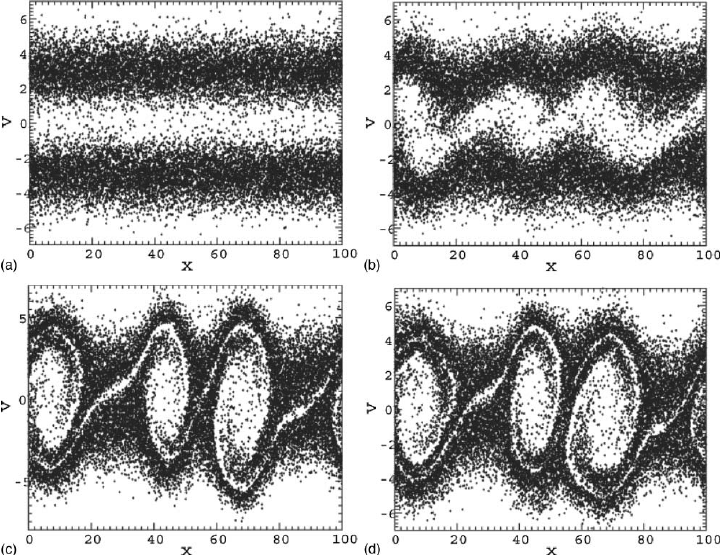

This problem applies to fluid dynamics as I have described, but it also applies to plasma physics and is one of the most basic problems studied.

The image above shows the behavior of a two stream instability in plasma using a similar approach (PIC) as I will, but with far more computing power. 

### Plasma Physics Background


Plasma is found all around us. In nature, it is found in the sun, lightening, and many other places. In industry it is used extensively in electronics, gas/fluorescent lamps, fusion energy research, and many others. 

There are primarily two equations that will be considered here: 

The Poisson Equation: $$ \nabla^2 \phi + \rho = 0 $$ 
The Vlasov Equation: $$ \frac{\partial{f}}{\partial{t}} + \vec{v} \cdot \frac{\partial{f}}{\partial{t}} + \frac{q}{m}(\vec{E} + \vec{v} \times \vec{B}) \cdot \frac{\partial{f}}{\partial{\vec{v}}} = 0 $$


Where: q is the particle's electric charge, 
     m is the particle's mass,
     and E(x,t) is the electric field.
     

### So what is the PIC method? What is the SOR method? How do we go about simulating a two stream instability?

The PIC method is one of the most popular methodes for solving certain types of partial differential equations such as the Poisson Equation. 

In the PIC method, space is divided into a grid or mesh with nodes at uniform spacing throughout the grid. Superparticles, representing many "normal" particles, are then tracked continuously through space corresponding to the grid of nodes.

#### There are four key steps to the PIC method:

1) Integration of equations of motion.

2) Assign charge and current values to field grid.

3) Compute the fields on the nodes in grid.

4) Assign field values from grid to particle location. 


In practice, the basic PIC algorithm looks like this:

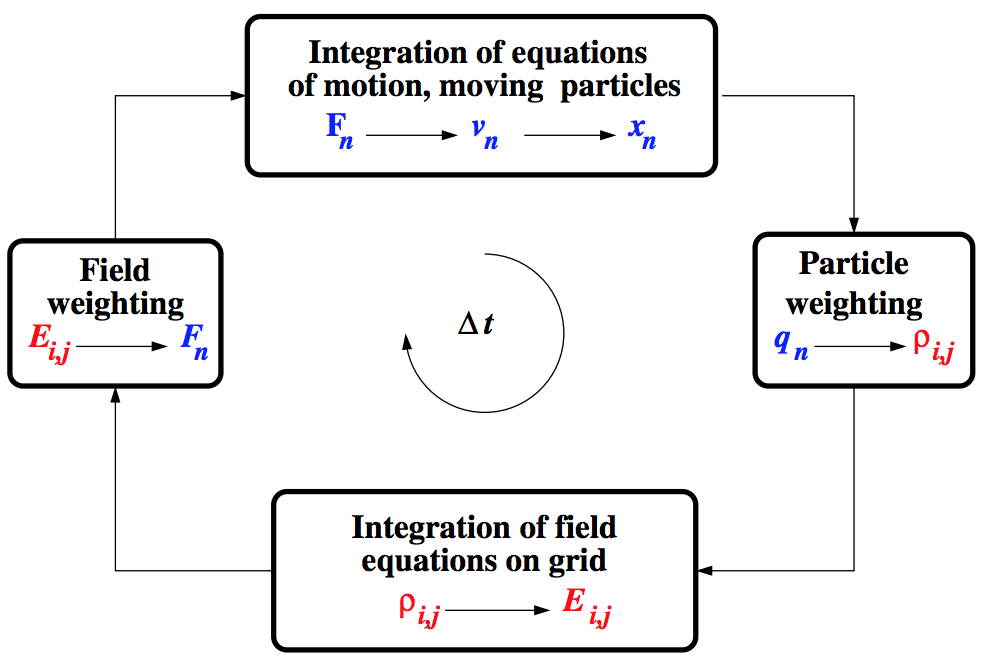


The grid and nodes described look like this: 

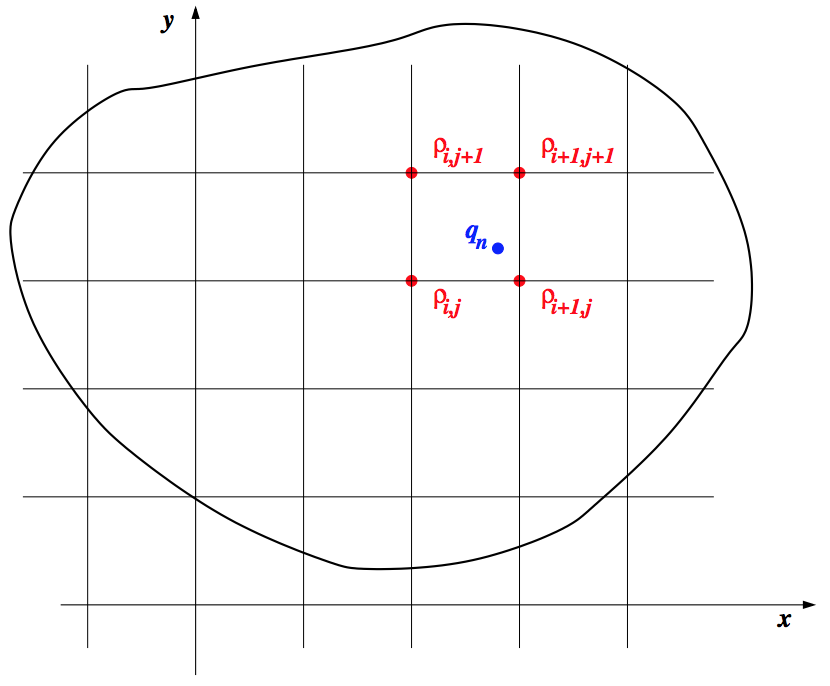

#### SOR method for solving Poisson Equation: 

The successive over-relaxation method allows us to solve the Poisson Equation (see above). It is an iterative process that loops through many times attempting to find a "solution" with an acceptable error. If implimented correctly, the guesses will converge to a good approximation of the correct value. In term of our simulation, it will allow us to calculate a new electric potential value from the old value and the electron/ion density. 

The Poisson equation can be rewriten in terms of a linear system of equations: 

$$ Ax = b $$

Where: A = the Lapacian (finite difference matrix)

We need to further rewrite the equation: 

1) $$  Ax = b $$
2) $$ (Ax)w = wb $$

Where w is the relaxation constant. 0 < w < 2

3) $$  (wD + wU + wL)x = wb $$

Where D, U, and L are the diagonal, upper, and lower matrix components of the A matrix. 

4) $$ (D + wL + wU + wD -D)x = wb $$
5) $$ [D + wL + wU + (w-1)D]x = wb $$
6) $$ (D + wL)x + [wU + (w-1)D]x = wb $$
7) $$ (D + wL)x = wb - [wU + (w-1)D]x $$
8) $$ x = (D + wL)^{-1} \cdot [wb - [wU + (w-1)D]x] $$

After triangular form of (D + wL); and using forward substitution:

9) $$ x = (1 - w)x + \frac{w}{a}(b - \sigma) $$ 
10) $$ x_{new} = (1 - w)x_{old} + \frac{w}{a}(b - \sigma) $$
11) $$ x_{new} = (1 - w)x_{old} + \frac{w}{a_{ii}}(b_{i} - \sum_{j<i}a_{ij}x_{j}^{k+1} - \sum_{j>i}a_{ij}x_{j}^{k})$$

Where sigma is the difference in sums of old and new.

12) $$ x_{i}^{k+1} = (1 - w)x_{i}^{k} + \frac{w}{a_{ii}}(b_{i} - \sum_{j<i}a_{ij}x_{j}^{k+1} - \sum_{j>i}a_{ij}x_{j}^{k})$$

Where k describes the current iteration or time step.

With "Physics variables" eq. 12 can we written as:

13) $$ \phi_{i}^{k+1} = (1 - w)\phi_{i}^{k} + \frac{w}{a_{ii}}(b_{i} - \sum_{j<i}a_{ij}x_{j}^{k+1} - \sum_{j>i}a_{ij}x_{j}^{k})$$

Where: phi is the electric potential, b is the right hand side of the eq. 1 and is a function of rho. 

This will allow us to find the new electric potential (phi new) from the old electric potential (phi old) and the current value of rho. 


## Setup and Parameters:

In [139]:
# System setup

NAME = 'two-stream_instability'    # name of setup configuration

CELLS = 100    # number of cells
NODES = CELLS + 1    # number of nodes
SIZE = 20    # size of system
STEPS = 2000    # number of time steps; how long to sim for

# Integration steps

dX = SIZE/CELLS   # distance between nodes in space 
dT = 0.1    # timestep 

# Particles
NPpc = 20    # number of particles per species per cell
NP = NPpc * CELLS    # number of particles of a species

# SOR
ERROR = 1e-5

# Plasma Parameters and Pertubation
omegaP = 1    # normalized plasma frequency 
eps0 = 1     # normalized vacuum permittivity

MODE = 1    # could use different pertubation modes
AMPLITUDE = 1e-1    # amplitude of plasma pertubation 

## Grid and Particle Stream Generation Class and Functions:

In [140]:
import numpy as np

# Particle class 

class Particle:
    
    # Initialize particle object
    def __init__(self, position, velocity, frequency, charge_over_mass, move_boolean, num_particles):
        
        # particle methodes
        self.x = position
        self.v = velocity
        self.omega = frequency
        self.q = omegaP**2 * (1/charge_over_mass) * eps0 * (SIZE/num_particles)
        self.qoverm = charge_over_mass 
        self.move = move_boolean
    
    # Two stream setup
    def two_stream_instability ():
        
        # array of particle objects in streams
        STREAM = []
        
        # separation
        separation = 1.0 * SIZE/(NP/2)
        
        # for loop through all flucuating particles
        for i in range(NP//2):
            
            # plasma flucuations are modelled as a background value (usually constant) plus a small pertubation
            
            # plasma background
            x_background = (i + 0.5) * separation
            
            # plasma pertubation
            angle_theta = 2 * np.pi * MODE * x_background / SIZE
            plasma_pert = AMPLITUDE * np.cos(angle_theta)
            
            # overall plasma flucuation
            x_1 = x_background + plasma_pert
            x_2 = x_background - plasma_pert
        
            # to cover all space and visit all nodes we need periodic boundary conditions
            if x_1 < 0:
                x_1 += SIZE
            if x_2 < 0:
                x_2 += SIZE
            if x_1 >= SIZE:
                x_1 -= SIZE
            if x_2 >= SIZE:
                x_2 -= SIZE
                
            # add flucuating/moving particles to stream
            STREAM.append(Particle(x_1, -1.0, 1.0, -1.0, True, NP))
            STREAM.append(Particle(x_2, 1.0, 1.0, -1.0, True, NP))
            
        # for loop for all background particles
        separation = SIZE/NP 

        for i in range(NP):
            
            # plasma background
            x_background = (i + 0.5) * separation
            
            # add stationary particles to stream
            STREAM.append(Particle(x_background, 0.0, 1.0, 1.0, False, NP))
        
        # return stream of objects
        return STREAM
    

## PIC Loop Functions: 

In [141]:
# Functions for four step PIC process using SOR. We will need six functions.


# 1) Density weighting on nodes of grid.

# Function takes in array of particles [particles]. INPUT = [particles]
# Function outputs density on nodes in grid. OUTPUT = rho 

def density(particles):
    
    rho = np.zeros(NODES)        # creates array rho with NODES number of values, each equal to 0.0
    length_particles = len(particles)
    
    for j in range(length_particles):
        
        # setup particle position, step, and distance values that are used for indexing
        position = (particles[j].x / dX)
        step = np.floor(particles[j].x / dX)
        distance = position - step
        
        # setup current and next index values 
        current_index = int(step)
        next_index = (current_index + 1)
        
        # add current and next rho charge (q) values 
        rho[current_index] += particles[j].q * (1.0 - distance)
        rho[next_index] += particles[j].q * distance

        
    # clever business to get right values in right places for repeating iterations    
    rho[NODES - 1] += rho[0]
    rho[0] = rho[NODES - 1]

    # create numpy array of rho values
    rho = np.array(rho)

    rho /= dX    # equivalent to rho = rho/dX

    return rho
    

In [142]:
# 2) Successive Over-Relaxation Method to solve Poisson Equation.

# Function takes in density (rho) array. INPUT = rho 
# Function outputs electric potential (phi) array. OUTPUT = phi

def SOR(rho):
    
    # relaxation constant w
    w = 2.0 / (1 + np.pi / NODES)
    # w = 1.92
    
    # create initial starting phi values
    phi = np.zeros(NODES)

    # create matrix b (see SOR description above) from density array rho
    matrix_b = -np.copy(rho) * dX**2 / eps0

    # SOR solver
    for k in range(10000):
        
        if k == 9999:    # if loop above gets to k = 9999 without finding acceptable solution (low enough error) then we have problem. 
                         # if k = 9999 then terms are not converging and SOR method fails
            print ("\nSOR (likely) diverges\n")
        phi_new = np.copy(phi)
        
        for i in range(NODES - 1):
            
            # create next and previous indices 
            next_index = (i + 1) if (i < NODES - 2) else 0
            previous_index = (i - 1) if (i > 0) else (NODES - 2)
            
            # SOR algorithm. See eq. 10 and 13 in SOR section above
            phi_new[i] = (1 - w) * phi[i] + (w / -2.0) * (matrix_b[i] - phi_new[previous_index] - phi[[next_index]])

        # checking convergence
        if k % 25 == 0:
            if np.max(np.abs(phi_new - phi)) < ERROR:
                phi = phi_new
                # print "SOR steps: ", k
                break
        phi = np.copy(phi_new)

    phi[NODES - 1] = phi[0] # move on to next
    
    return phi


In [143]:
# 3) Calculating the electric field from the potential on nodes in grid

#   Function takes in array of the potential on nodes. INPUT = phi
#   Function outputs in array of electric fields on the nodes. OUTPUT = electric field on nodes array

def field_on_nodes (phi):
    
    # initial electric field values
    electric_field = np.zeros(NODES)
    
    for i in range(NODES):
        next_index = (i + 1) if (i < NODES - 1) else 0
        previous_index = (i - 1) if (i > 0) else (NODES - 1)

        electric_field[i] = (phi[previous_index] - phi[next_index]) / (2 * dX)

    return electric_field

In [144]:
# 4) Assign the electric field values from nodes to particles. Interpolate field from nodes to particles.

# Function takes in array of electric field on nodes and array of particles. INPUT = array of electic field on nodes, and array of particles
# Function outputs array of electric field on particles. OUTPUT = array of electric field on particles 

def field_on_particles (field, particles):
    
    length_particles = len(particles)
    
    # create initial electric field array
    electric_field = np.zeros(length_particles)
    
    for k in range(length_particles):
        
        if particles[k].move:
            
            position = (particles[k].x // dX)
            step = np.floor(particles[k].x // dX)

            next_index = (step + 1) if (step + 1) < NODES else 0

            electric_field[k] = (next_index - position) * field[int(step)] + (position - step) * field[int(next_index)]
            
    return electric_field

In [145]:
# 5) Equations of motion integration

#   Function takes in electric field and particles array. INPUT = field and array array
#   Function outputs new particles velocities and positions. OUTPUT = particle velocities and positions.

def move_particles(field, particles):
    
    length_particles = len(particles)
    
    for k in range(length_particles):
        if particles[k].move:
            
            # update new velocity
            particles[k].v += field[k] * particles[k].qoverm * dT

            # updating position
            particles[k].x += particles[k].v * dT

            # boundardy conditions
            while particles[k].x < 0:
                particles[k].x += SIZE
            while particles[k].x >= SIZE:
                particles[k].x -= SIZE
                
    return particles

In [146]:
# 6) Function for rewinding velocity by dT/2 forward or backward

#   Function takes in rewind direction, field, and particles arrays. INPUT = rewind direction, field, particles
#       direction forward: +1
#       direction backward: -1
#   Function outputs new particle velocities. OUTPUT = new particles velocties

def rewind(direction, field, particles):
    
    length_particles = len(particles)
    
    for k in range(length_particles):
        
        #f updating new velocity
        if particles[k].move:
            
            particles[k].v += direction * field[k] * particles[k].qoverm * dT / 2.0
            
    return particles

## Math Plot Library Progress Bar

In [147]:
# Print iterations progress

import sys

def printProgress (iteration, total, prefix = '', suffix = '', decimals = 2, barLength = 100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : number of decimals in percent complete (Int)
        barLength   - Optional  : character length of bar (Int)
    """
    filledLength    = int(round(barLength * iteration / float(total)))
    percents        = round(100.00 * (iteration / float(total)), decimals)
    bar             = u'\u2588' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
    sys.stdout.flush()
    if iteration == total:
        sys.stdout.write('\n')
        sys.stdout.flush()

## PIC Function Calls

In [148]:
# Main

# Function to check file NAME 
# if file parameters exist, generate initial particles

if NAME == 'two-stream_instability':
    
    # calling Particle class to generate initial particles
    particles = Particle.two_stream_instability()
    
else:
    print('Invalid NAME, no parameters exist for input NAME given')
    
# here we could add more 'cases' for NAMES if we had other instabilities we wanted to explore


# PROGRESS BAR
stp = 0
printProgress(stp, STEPS, prefix = 'Progress:', suffix = 'Complete', barLength = 50)


# core PIC loop
for step in range(STEPS):
    
    # PIC Steps
    
    # 1) Assign densities
    rho = density(particles)
    
    # 2) SOR method to solve Poisson and calculate phi values
    phi = SOR(rho)
    
    # 3) Assign the electric field values from nodes to particles
    electric_field_nodes = field_on_nodes(phi)
    
    # 4) Calculate electric field on particles 
    electric_field_particles = field_on_particles(electric_field_nodes, particles)

    if step == 0:
        particles = rewind(-1, electric_field_particles, particles)

    particles = move_particles(electric_field_particles, particles)
    
    
    # WRITE TO FILES
    
    if step % 1 == 0:
    
        # print "step: ", step
    
        output = open('/Users/Aidanklemmer/Desktop/Two Stream Instability Python/Math Methods/2000 Step Data/' + 'step_' + str(step) + '.dat', 'w')
    
        newparts = rewind(1, electric_field_particles, particles)
        length_particles = len(particles)
    
        # write to write
        for i in range(length_particles):
            if newparts[i].move:
                output.write(str(newparts[i].x) + ' ' + str(newparts[i].v) + '\n')
        output.close()
    
    # PROGRESS BAR
    stp += 1
    printProgress(stp, STEPS, prefix = 'Progress:', suffix = 'Complete', barLength = 50)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


## Animate Data

animation file is ready


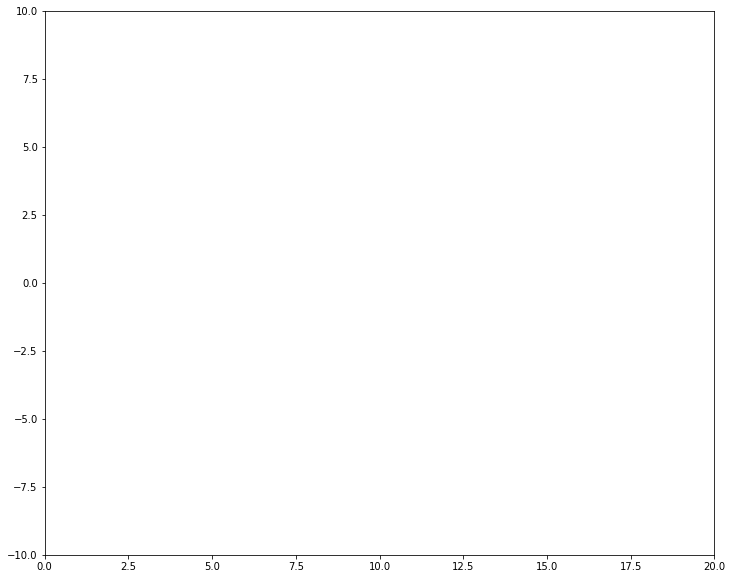

In [150]:
# import libraries 
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation

# call ffmpeg writers
#plt.rcParams['animation.ffmpeg_path'] = '/Users/Aidanklemmer/Desktop/Two Stream Instability Python/ffmpeg/'
writer = animation.writers['ffmpeg']
writer = writer(fps=30, bitrate=1800)

# sizing
fig = plt.figure()
fig.set_size_inches(12, 10)
ax = plt.axes(xlim=(0, SIZE), ylim=(-10, 10))

# scatter plot
scat = ax.scatter([], [], lw=0, s=10)
colors_ini = np.zeros((NP, 3))

def init():
    scat.set_offsets([])
    return scat

# define colors for particles
def getColor(vel):
    for i in range(len(vel)):
        if vel[i] < 0:
            colors_ini[i] = [1,0,0]
        else:
            colors_ini[i] = [0,0,0]
    return colors_ini

# read data files and animate
def animate(i):
    
    # location of storage data files
    filename = '/Users/Aidanklemmer/Desktop/Two Stream Instability Python/Math Methods/2000 Step Data/' + 'step_' + str(i) + ".dat"
    
    # unpack data into two arrays; one for position and one for velocity 
    pos, vel = np.loadtxt(filename, delimiter=' ', unpack=True)
    
    # copy data to numpy array
    data = np.array([pos, vel]).copy().T
    
    # generate colors
    if i == 0:
        colors = getColor(vel)
    else:
        colors = colors_ini
    
    # create scatter plot from data and colors
    scat.set_offsets(data)
    scat.set_color(colors)
    return scat

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=STEPS, interval=1)
anim.save('/Users/Aidanklemmer/Desktop/Two Stream Instability Python/Math Methods/Animations/' + str(STEPS) + ' Step' + '.mp4', writer=writer)

print('animation file is ready')

## While we wait...

Some examples of the two stream instability:

https://www.youtube.com/watch?v=__7GQS15IdE

https://www.youtube.com/watch?v=LVhx40I-xAg

$$ \frac{\partial f}{\partial t} + \vec v \cdot \frac{\partial f}{\partial x} + \frac{qE}{m} \cdot \frac{\partial f}{\partial \vec v}  = 0 $$ 

$$ f(x,v,t) $$

$$ \frac{\partial x}{\partial t} = \vec v $$

$$ \frac{\partial \vec v}{\partial t} = \frac{q}{m}(\vec E) $$

$$ \nabla^{2}\phi + \rho = 0 $$ 